In [65]:
import os
import glob
import tqdm
import torch
import numpy as np
import omegaconf
from mllib.src.train import main

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch.cuda
from mllib.src.evaluate import evaluate
from mllib.src.utils import prepare_device, load_yaml

In [66]:
# config = "./result/demucs/20230201-104202/config.yaml"
# config = "./result/wav-unet/20230201-104328/config.yaml"
# config = "./result/dcunet/20230201-104116/config.yaml"
# config = "/home/daniel0413/workplace/project/SpeechEnhancement/SpeechEnhancementHL/result/dcunet/20230128-234556/config.yaml"
config = "./mllib/result/mel-rnn/20230202-145405/config.yaml"
# config = "./mllib/result/dnn/20230202-142249/config.yaml"
# config = "./mllib/result/dnn/20230202-163959/config.yaml"
# config = "./mllib/result/dnn/20230202-170504/config.yaml"
# config = "./mllib/result/dnn/20230202-171624/config.yaml"
# config = "./mllib/result/dnn/20230202-185453/config.yaml"

In [67]:
solver = main(path_config=config, return_solver=True)

------------------------------
	Search training datasets...
ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/noisy_trainset_28spk_wav
Folder:  []
Files:  ['p244_208.wav', 'p243_260.wav', 'p287_204.wav', 'p226_064.wav', 'p244_369.wav', 'p227_270.wav', 'p228_091.wav', 'p231_237.wav', 'p277_374.wav', 'p243_176.wav']

ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/noisy_trainset_56spk_wav
Folder:  []
Files:  ['p251_129.wav', 'p292_072.wav', 'p245_116.wav', 'p314_175.wav', 'p249_086.wav', 'p307_241.wav', 'p295_174.wav', 'p347_369.wav', 'p247_047.wav', 'p265_245.wav']

ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/clean_trainset_56spk_wav
Folder:  []
Files:  ['p251_129.wav', 'p292_072.wav', 'p245_116.wav', 'p314_175.wav', 'p249_086.wav', 'p307_241.wav', 'p295_174.wav', 'p347_369.wav', 'p247_047.wav', 'p265_245.wav']

ROOT:  ./mllib/data/VoiceBankDEMAND/DS_10283_2791/clean_trainset_28spk_wav
Folder:  []
Files:  ['p244_208.wav', 'p243_260.wav', 'p287_204.wav', 'p226_064.wav', 'p244_369

In [68]:
test_data = solver.test_dataloader
model = solver.model

In [69]:
args = load_yaml(config)
n_gpu = torch.cuda.device_count()
device = prepare_device(n_gpu, cudnn_deterministic=args.solver.cudnn_deterministic)

Using CuDNN deterministic mode in the experiment.


In [70]:
args.default.dset.name = "Clarity"

if args.default.dset.name == "VoiceBankDEMAND":
    log_voicebank = "./mllib/data/VoiceBankDEMAND/DS_10283_2791/logfiles"
    text_files = glob.glob(
        os.path.join(log_voicebank, "*trainset*")
    )
    print(text_files)
    metadata = []
    for text_file in text_files:
        with open(text_file, "r") as tmp:
            text = tmp.read().split("\n")
            for i, t in enumerate(text):
                text[i] = t.split(" ")
        
            metadata.append(text)
    print(metadata[0][0])

elif args.default.dset.name == "Clarity":
    log_clarity = "/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/custom_metadata/scenes.train.snr.json"
    metadata = omegaconf.OmegaConf.load(log_clarity)
    print(list(metadata.values())[0], list(metadata.keys())[0])

1.1382 S00001


In [71]:
from mllib.src.distrib import get_train_wav_dataset

SNR = '0' # '0', '5', '10', '15' # SNR = P_{Signal} / P_{Noise}

test_dataset = None

if args.default.dset.name == "VoiceBankDEMAND":
    args.dset.wav = './mllib/data/VoiceBankDEMAND/DS_10283_2791'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset, name="VoiceBankDEMAND")

elif args.default.dset.name == "Clarity":
    args.dset.wav = '/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data'
    args.default.dset.config = './recipes/icassp_2023/MLbaseline/config_train.yaml'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset, name="Clarity")

dataset = test_dataset

flag_find = False
data_test = None

if args.default.dset.name == "VoiceBankDEMAND":
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, clean, origial_length, name = data
        for imetadata in range(len(metadata)):
            for ifile in range(len(metadata[imetadata])):
                if metadata[imetadata][ifile][0] == name:
                    if metadata[imetadata][ifile][-1] == SNR:
                        flag_find = True
                    else:
                        break
        if flag_find:
            data_test = data
            break

elif args.default.dset.name == "Clarity":
    # data_test = dataset[0]
    # mixture, clean, origial_length, name = data_test
    # scene_name = name.split("_")[0]
    # SNR = metadata[scene_name]
    # print("Clarity dataset SNR: ", SNR)

    SNR = 5
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, clean, origial_length, name = data
        scene_name = name.split("_")[0]
        if metadata[scene_name] > SNR:
            data_test = data
            SNR = metadata[scene_name]
            break
    
    print("Clarity dataset SNR: ", SNR)

# data_test

	 Original length: 22800
	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300


  3%|██▏                                                                                | 8/300 [00:00<00:24, 11.76it/s]

Clarity dataset SNR:  5.0611


In [72]:
mixture, clean, origial_length, name = data_test

In [73]:
nchannel, nsample = mixture.shape
if args.model.name in ("demucs", "conv-tasnet") and nchannel == 1:
    try:
        mixture = torch.cat(tensors=[mixture, mixture], dim=1)
        clean = torch.cat(tensors=[clean, clean], dim=1)
    except AttributeError:
        # For torch 1.7.1, AttributeError: module 'torch' has no attribute 'concat'
        mixture = torch.cat(tensors=[mixture, mixture], dim=1)
        clean = torch.cat(tensors=[clean, clean], dim=1)

if args.model.name not in ("demucs", "conv-tasnet"):
    mixture = torch.reshape(mixture, shape=(nchannel, 1, nsample))


In [74]:
mixture.shape

torch.Size([2, 1, 99526])

In [75]:
enhanced = evaluate(mixture=mixture, model=model, device=device, config=args)

In [76]:
assert enhanced.shape[-1] == mixture.shape[-1] == clean.shape[-1]

In [77]:
enhanced = enhanced.detach().cpu()

In [78]:
enhanced.shape, mixture.shape, clean.shape

(torch.Size([2, 1, 99526]), torch.Size([2, 1, 99526]), torch.Size([2, 99526]))

In [79]:
enhanced_np = enhanced.flatten().numpy()
mixture_np = mixture.flatten().numpy()
clean_np = clean.flatten().numpy()

In [80]:
enhanced_np = enhanced_np[:]
mixture_np = mixture_np[:]
clean_np = clean_np[:]

In [81]:
enhanced_np.shape, mixture_np.shape, clean_np.shape

((199052,), (199052,), (199052,))

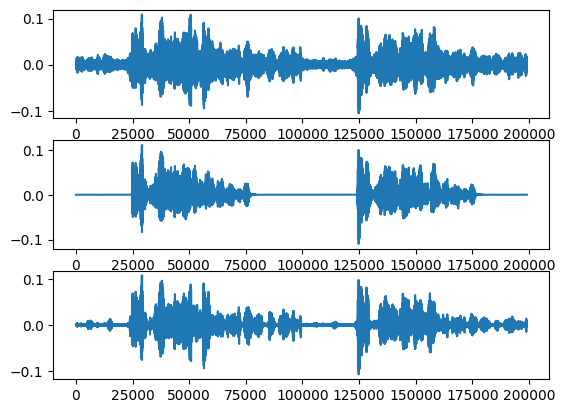

In [82]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)

ax0.plot(mixture_np)
ax1.plot(clean_np)
ax2.plot(enhanced_np)


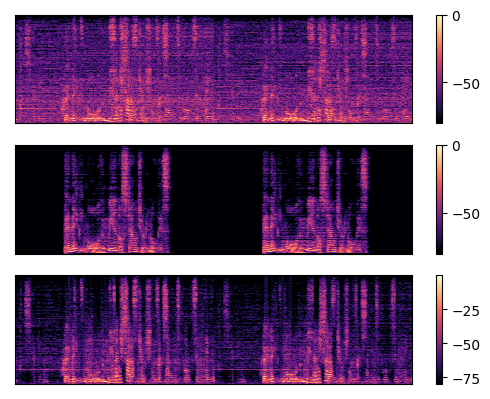

In [83]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(mixture_np, fig, ax0)
show_stft(clean_np, fig, ax1)
show_stft(enhanced_np, fig, ax2)

In [84]:
ipd.Audio(mixture_np, rate=args.dset.sample_rate)

In [85]:
ipd.Audio(clean_np, rate=args.dset.sample_rate)

In [86]:
ipd.Audio(enhanced_np, rate=args.dset.sample_rate)

In [87]:
from mllib.src.metric import SI_SDR, STOI, WB_PESQ

In [88]:
metrics = [SI_SDR, STOI, WB_PESQ]

clean_score = np.expand_dims(np.expand_dims(clean_np, 0), 0)
mixture_score = np.expand_dims(np.expand_dims(mixture_np, 0), 0)
enhanced_score = np.expand_dims(np.expand_dims(enhanced_np, 0), 0)

print(clean_score.shape, mixture_score.shape, enhanced_score.shape)

for metric in metrics:
    print("Mixture", metric, metric(clean_score, mixture_score, sr=args.dset.sample_rate))
    print("Enhanced", metric, metric(clean_score, enhanced_score, sr=args.dset.sample_rate))

(1, 1, 199052) (1, 1, 199052) (1, 1, 199052)
Mixture <function SI_SDR at 0x7fd4a339b940> 2.854131758213043
Enhanced <function SI_SDR at 0x7fd4a339b940> 2.907755672931671
Mixture <function STOI at 0x7fd4840deaf0> 0.7171769889298053
Enhanced <function STOI at 0x7fd4840deaf0> 0.5959689672581248
Mixture <function WB_PESQ at 0x7fd4840deb80> 0
Enhanced <function WB_PESQ at 0x7fd4840deb80> 0
